## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Лебеденко  |
|---------|------------|
| Группа  | М8о-301Б-19|

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

Теперь загружаем датасет:

In [1]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [2]:
import numpy as np

In [3]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features'].astype(np.float32)/256

Смотрим на то, какие данные получились:

In [4]:
data.shape

(42000, 784)

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку

In [5]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels,test_size=0.25)

In [6]:
import matplotlib.pyplot as plt 
from matplotlib import gridspec

In [7]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

In [8]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

In [9]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)
                
    def compile(self, loss=None, metrics=["accuracy"]):
        self.loss = loss
        self.metrics = metrics
    
    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.loss.forward(p,y)
        pred = np.argmax(p,axis=1)
        acc = (pred==y).mean()
        return l, acc
    
    def fit(self, X_train, y_train, batch_size=4, epochs=10, validation_data=None, lr=0.3):
        X_test, y_test = validation_data
        history = []
        train_loss, train_acc = self.get_loss_acc(X_train, y_train)
        test_loss, test_acc = self.get_loss_acc(X_test, y_test)
        history.append([train_acc,train_loss,test_acc,test_loss])
        
        for i in range(4):
            print(f"Initial {['train_acc','train_loss','test_acc','test_loss'][i]}: {history[-1][i]}")

        for epo in range(epochs):
            for i in range(0,len(X_train),batch_size):
                xb = X_train[i:i+batch_size]
                yb = y_train[i:i+batch_size]
                p = self.forward(xb)
                l = self.loss.forward(p,yb)
                dp = self.loss.backward(l)
                dx = self.backward(dp)
                net.update(lr)
            train_loss, train_acc = self.get_loss_acc(X_train, y_train)
            test_loss, test_acc = self.get_loss_acc(X_test, y_test)
            history.append([train_acc,train_loss,test_acc,test_loss])
            print(f"epoch: {epo+1}/{epochs}")
            for i in range(4):
                print(f"{['train_acc','train_loss','test_acc','test_loss'][i]}: {history[-1][i]}")
            #print("confusion matrix:", self.get_conf_mat(X_train, y_train), sep='\n')
        return history

In [10]:
net = Net()
net.add(Linear(784, 10))
net.add(Softmax())
net.compile(loss=CrossEntropyLoss())

hist = net.fit(train_data,train_labels, lr=0.001, epochs=30, batch_size=256, validation_data=(test_data,test_labels))

Initial train_acc: 0.06282539682539683
Initial train_loss: 2.3659036015499297
Initial test_acc: 0.05704761904761905
Initial test_loss: 2.3678878269523347
epoch: 1/30
train_acc: 0.1593015873015873
train_loss: 2.2194284508192283
test_acc: 0.15542857142857142
test_loss: 2.2216882501268214
epoch: 2/30
train_acc: 0.3140952380952381
train_loss: 2.096086757281105
test_acc: 0.31276190476190474
test_loss: 2.0986757949809003
epoch: 3/30
train_acc: 0.4687936507936508
train_loss: 1.9870858431607774
test_acc: 0.4659047619047619
test_loss: 1.9900087323333566
epoch: 4/30
train_acc: 0.5756825396825397
train_loss: 1.8888110426021196
test_acc: 0.5737142857142857
test_loss: 1.8920542921242145
epoch: 5/30
train_acc: 0.6405396825396825
train_loss: 1.7995587637259847
test_acc: 0.6342857142857142
test_loss: 1.8031024752939182
epoch: 6/30
train_acc: 0.6796190476190476
train_loss: 1.718308152065897
test_acc: 0.6735238095238095
test_loss: 1.7221309910108307
epoch: 7/30
train_acc: 0.7062857142857143
train_loss: 

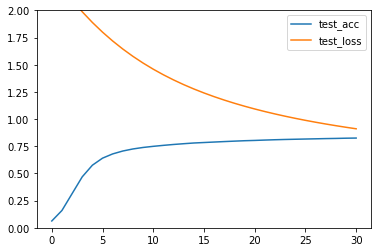

In [11]:
plt.clf()
plt.ylim(0, 2.0)
for i in range(2):
    plt.plot([val[i] for val in hist], label=['test_acc','test_loss'][i])
plt.legend()

In [12]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

In [13]:
net = Net()
net.add(Linear(784, 300))
net.add(Tanh())
net.add(Linear(300,10))
net.add(Softmax())
loss = CrossEntropyLoss()

net.compile(loss=CrossEntropyLoss())

hist = net.fit(train_data, train_labels, lr=0.001, epochs=30, batch_size=256, validation_data=(test_data,test_labels))

Initial train_acc: 0.08292063492063492
Initial train_loss: 2.4130687032650964
Initial test_acc: 0.08495238095238095
Initial test_loss: 2.4089791599862718
epoch: 1/30
train_acc: 0.18034920634920634
train_loss: 2.245265259386243
test_acc: 0.18047619047619048
test_loss: 2.241599596498903
epoch: 2/30
train_acc: 0.3461904761904762
train_loss: 2.1019775664306626
test_acc: 0.3525714285714286
test_loss: 2.09889616665357
epoch: 3/30
train_acc: 0.471015873015873
train_loss: 1.9743935292395574
test_acc: 0.47904761904761906
test_loss: 1.9719420900332316
epoch: 4/30
train_acc: 0.5717777777777778
train_loss: 1.859328441430757
test_acc: 0.5764761904761905
test_loss: 1.8575055642643166
epoch: 5/30
train_acc: 0.6411746031746032
train_loss: 1.7550915707100543
test_acc: 0.644
test_loss: 1.753877045937089
epoch: 6/30
train_acc: 0.6868888888888889
train_loss: 1.6604946420211124
test_acc: 0.6900952380952381
test_loss: 1.6598612022508266
epoch: 7/30
train_acc: 0.7152698412698413
train_loss: 1.574571512884438

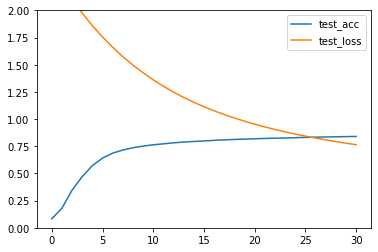

In [14]:
plt.clf()
plt.ylim(0, 2.0)
for i in range(2):
    plt.plot([val[i] for val in hist], label=['test_acc','test_loss'][i])
plt.legend()